# MPlot tutorial

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!


**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed. You can check more examples in [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view). You will also find lots more datasets at his GoogleDrive. [This powerpoint](https://www.slideserve.com/mickie/ucr-time-series-semantic-segmentation-archive-powerpoint-ppt-presentation) explains the content of some of them in a simple way, including the Pulsus Paradoxus dataset.

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)
- `execute_01`. Put this flag to true in case you have never executed the 01_<> notebook for the PulsusParadoxus dataset. Please change it to false one the celss in the section `Execute '1` have already been executed. It does not take very long, but it is some time ;).

In [3]:
#| export
# Configuration paramaters
print_flag                    = True
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1

In [4]:
print("--- Check parameters ---")
print(
    "print_flag (for printing or not messages):", print_flag, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
print_flag (for printing or not messages): True 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [5]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [6]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f15525c6230>

















## Generate & Train S3

In [7]:
#-- For setting up the parameters
import os
import torch
from typing import Tuple, Dict

#-- Specific
from ploomber_engine import execute_notebook

##### Ensure the correct configuration for ploomber engine execution

In [8]:
def get_parameters(nb_id : int ) -> Tuple[ str, Dict ]:
    inpath = '~/work/nbs_pipeline'
    outpath = '~/work/nbs_pipeline/output'
    match nb_id:
        case 1:
            filename = "01_dataset_artifact"
            parameters = parameters_01 = {
              'print_flag'                    : False,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 2: 
            filename   = "02b_encoder_MVP"
            parameters = parameters_02 = {
              'print_flag'                    : False,
              'check_memory_usage'            : False,
              'time_flag'                     : False,
              'window_size_percentage'        : None,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 10:
            filename   = "_synthetic_data"
            inpath     = "~/work/nbs"
            parameters = {}
            
        case _:
            print("Invalid configuration")
            filename = ""
            inpath = ""
            outpath = ""
            parameters = {}
    return filename,parameters, inpath, outpath

In [9]:
def get_input_output(
    nb_id   : int
) -> Tuple[ str, str, Dict ]:
    filename,parameter, inpath, outpath = get_parameters(nb_id)
    inbpath    = os.path.expanduser(inpath)
    onbpath    = os.path.expanduser(outpath)
    extension  = ".ipynb"
    reportname = filename+"-output"
    inputnb    = inbpath+"/"+filename+extension
    outputnb   = onbpath+"/"+reportname+extension
    print(f"Executing {inputnb} into {outputnb}")
    return parameter, inputnb, outputnb

In [10]:
# Put to true when you need to restore S3 or whatever
generate_S3 = False
execute_01  = False
execute_02  = False

##### Generate S3

In [11]:
if generate_S3:
    parameters, inputnb, outputnb = get_input_output(10)
    print(parameters)
    print(inputnb)
    print(outputnb)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )

##### Execute 01: Load artifact to W&B

In [12]:
if execute_01:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

##### Execute 02: Train MTSAE

In [13]:
if execute_02:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(2)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [14]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [15]:
#| export
warnings.filterwarnings("ignore", module="wandb")
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 22
GPU | Used mem: 24
GPU | Memory Usage: [██████████████████--] 92%


### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [16]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [17]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

### Setup Weights & biases artiffact

In [18]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_S3"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: _MPlot_S3
alias: S3
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (25, 50)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 9
train_artifact: mi-santamaria/deepvats/S3:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 50
wandb_group: None


In [19]:
job_type = 'MPlot'
job_type

'MPlot'

## Start W&B Run

In [20]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact

In [21]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")

alias: S3
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [25, 50]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 9
train_artifact: mi-santamaria/deepvats/S3:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 50
wandb_group: None
---> W&B Train Artifact


### Transform to dataframe

In [22]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [23]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(28800, 1)


<bound method NDFrame.head of                      Seasonal time series w/ noise and trend
1970-01-01 00:00:00                               -15.677224
1970-01-01 00:01:00                               -25.792981
1970-01-01 00:02:00                               -23.422229
1970-01-01 00:03:00                               -19.127490
1970-01-01 00:04:00                               -26.858897
...                                                      ...
1970-01-20 23:55:00                                36.241574
1970-01-20 23:56:00                                44.324594
1970-01-20 23:57:00                                40.664762
1970-01-20 23:58:00                                39.089744
1970-01-20 23:59:00                                28.133159

[28800 rows x 1 columns]>

df_train ~  (28800, 1)
window_sizes =  [25, 50]
wlen =  50


## Check the MatrixProfile

In [24]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 22
GPU | Used mem: 24
GPU | Memory Usage: [██████████████████--] 92%


### Initialize parameters

In [25]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [26]:
# Use step for selecting values in position k*step 
ts_step = 1
ts_resampled = df_train.resample('15T').mean()
ts_resampled = ts_resampled.fillna(0)
ts = ts_resampled.iloc[:, 0].values
ts

array([-19.19242747, -19.41490381, -14.65240145, ...,  31.62466013,
        32.3247586 ,  38.98218773])

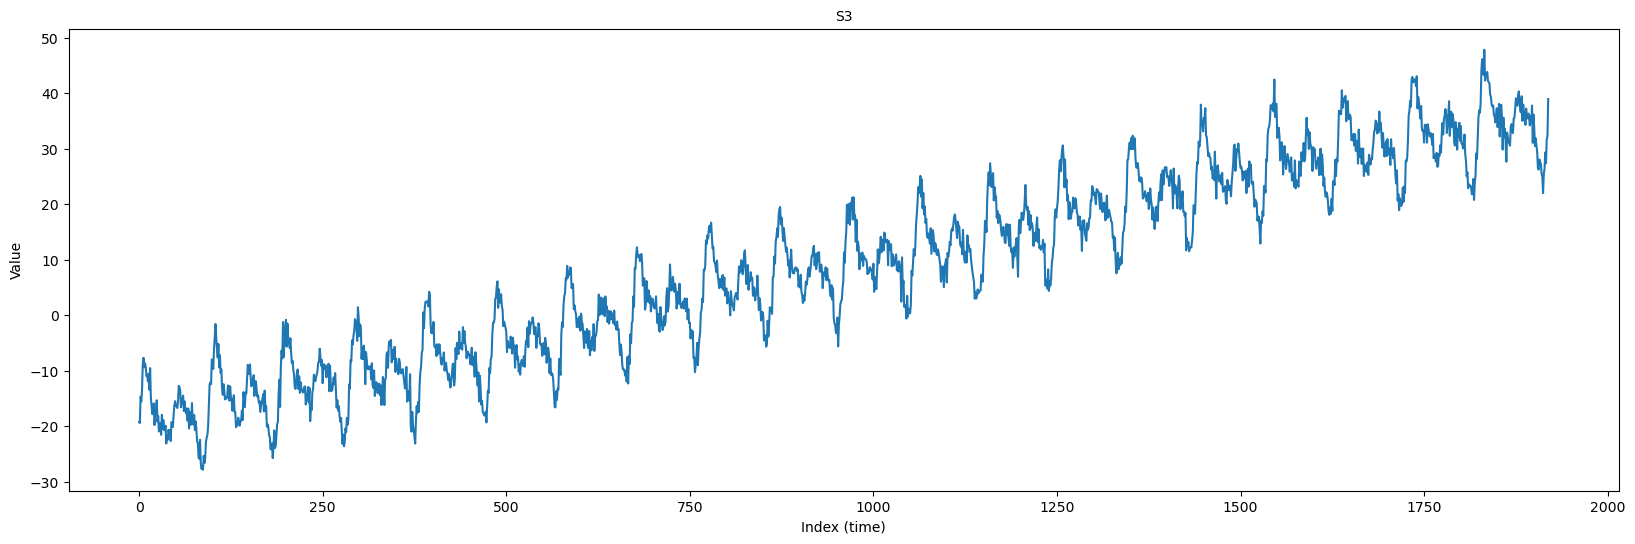

In [27]:
%matplotlib inline
plt.close("all")
mplots.plot_with_dots(
    time_series = ts, 
    title = "S3", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (20,6)
)

### Build the MatrixProfile object

In [28]:
pulsus_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

In [29]:
print(len(ts))
x = len(ts)/20
print(x)


1920
96.0


### Choose window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [30]:
pulsus_mp.provide_lens(1)
pulsus_mp.dominant_lens

[24]

In [31]:
m = 96 #pulsus_mp.dominant_lens[0]

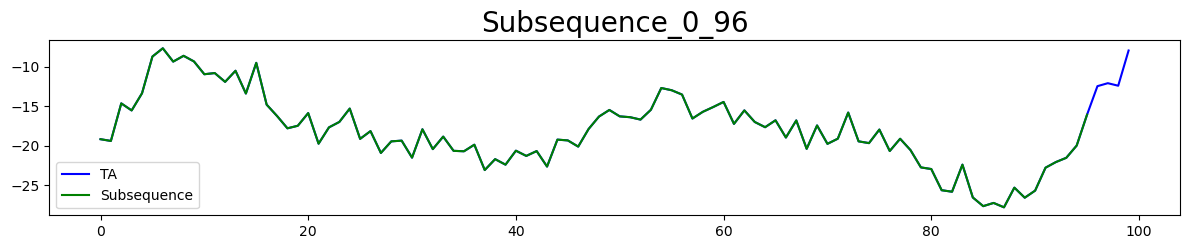

In [32]:
mplots.plot_subsequence(
    TA = ts[:100], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

And what happens if we use the double?

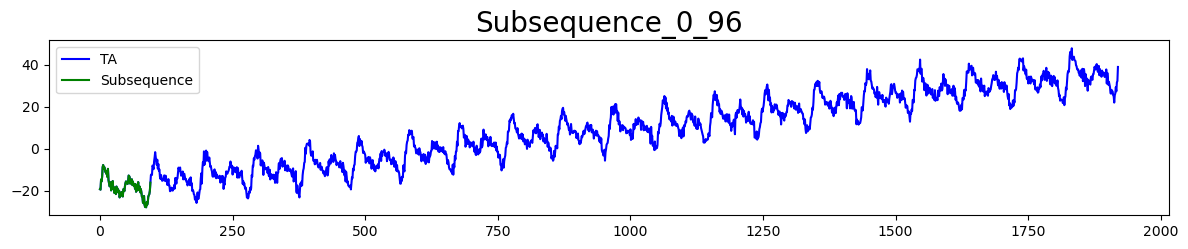

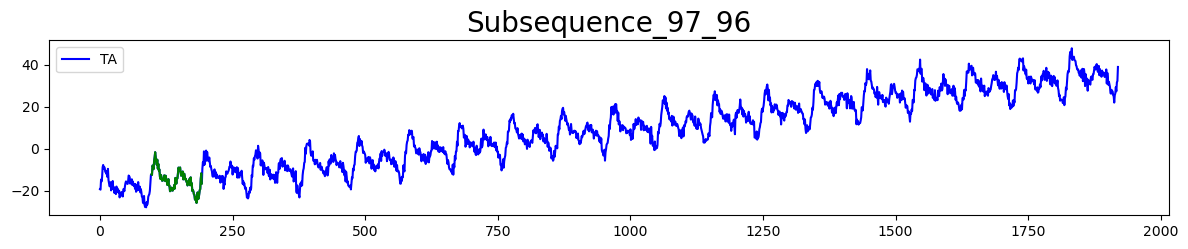

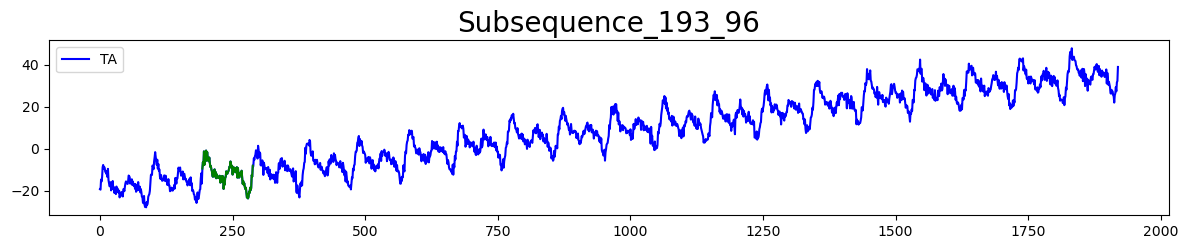

In [33]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

### Compute the Matrix Profile

In [34]:
pulsus_mp.subsequence_len = m

In [35]:
pulsus_mp.compute(
    print_flag = True, 
    d = mplots.z_normalized_euclidean_distance, 
    method = 'stump'
)

--> matrix profile
--> Stump (CPU)
MP | Compute | Using stumpy.stump | normalize? True
matrix profile 20.151869297027588 seconds -->


array([3.743029856696901, 3.739999160005172, 3.7327563692770562, ...,
       3.7336166393273587, 3.7319988291753683, 3.8356590170898723],
      dtype=object)

In [36]:
len(pulsus_mp.index)

1825

### Visualization of the matrix profile

With the interactive plot we can visually check the motif and anomaly indexes.
The previous and next buttons can be used for going subsequence by subsequence whereas the Motif and Discord buttons show the associated subsequences.

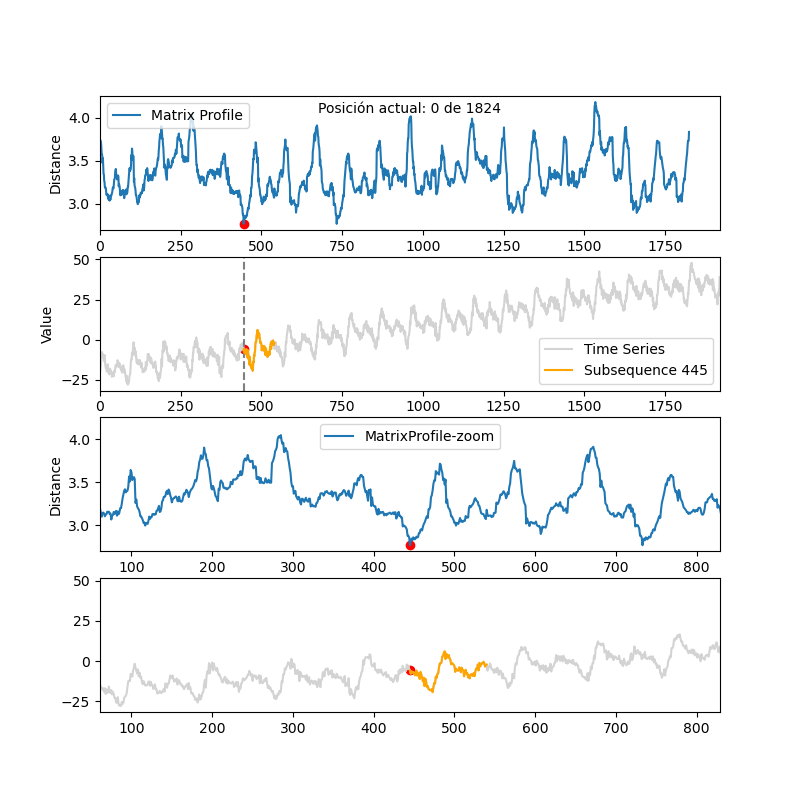

In [37]:
%matplotlib widget
pulsus_mp.plot_interactive(
    figsize = (8,8),
    print_flag =  False
)

### Direct computation & related metadata

#### Motif

In [38]:
pulsus_mp.get_motif_idx(print_flag = print_flag)

motif id 445 index ~  1825


(445, 733, 61, 733)

In [39]:
print(pulsus_mp.motif_idx)
print(pulsus_mp.motif_nearest_neighbor_idx)
print(pulsus_mp.motif_nearest_neighbor_idx_left)
print(pulsus_mp.motif_nearest_neighbor_idx_right)


445
733
61
733


#### Discord/Anomaly

In [40]:
pulsus_mp.get_anomaly_idx(print_flag = print_flag)

motif id 1534 index ~  1825
Nearest  1055
Nearest left  1055
Nearest right  1631


(1534, 1055, 1055, 1631)

In [41]:
print(pulsus_mp.discord_idx)
print(pulsus_mp.discord_nearest_neighbor_idx)
print(pulsus_mp.discord_nearest_neighbor_idx_left)
print(pulsus_mp.discord_nearest_neighbor_idx_right)

1534
1055
1055
1631


## Check the MPlot

### Build the MatrixProfilePlot object

In [42]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [43]:
#| hide
print("MP_AB self_join", data_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {data_MPlot.DM_AB.shape}")
print("MP_AB method:", data_MPlot.MP_AB.method)
print("DM_AB method:", data_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


### Compute the Similarity Matrix

In [44]:
data_MPlot.subsequence_len

96

In [45]:
# z-normalized euclidean distance
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import correlation
from scipy.spatial.distance import cityblock
def zeuclidean(u,v): return euclidean(zscore(u), zscore(v));
def distance(u,v):
    #-- euclidean
    #return euclidean(u,v)
    #-- z_normalized euclidean
    #return zeuclidean(u,v)
    #-- Pearson correlation
    #return correlation(u,v)
    return cityblock(u,v)

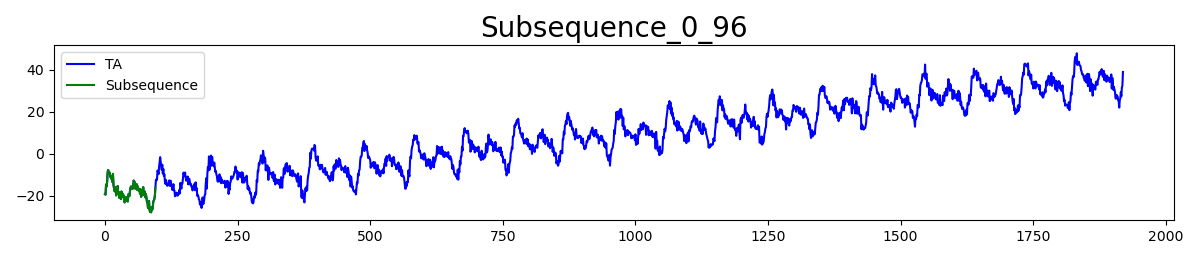

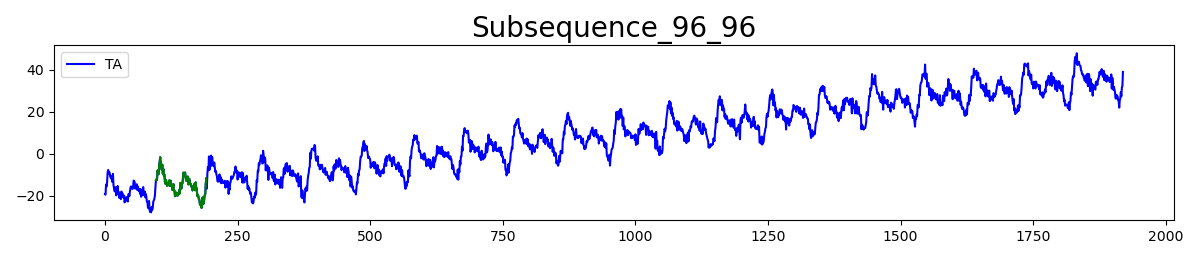

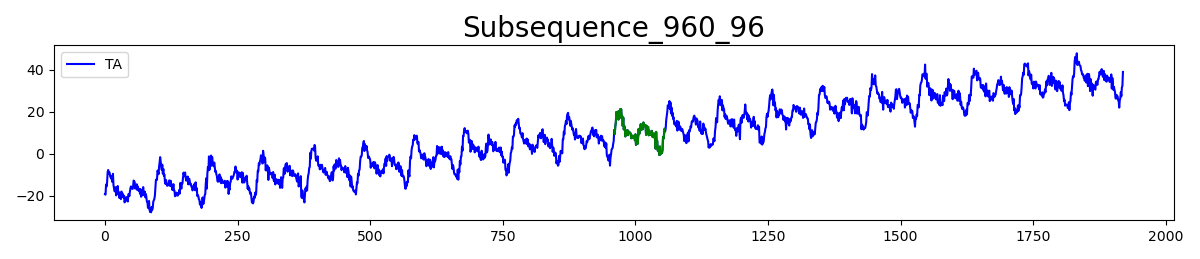

In [46]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = m,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 10*m,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

In [47]:
print(euclidean(ts[0:m], ts[m:m+m]))
print(euclidean(ts[m:m+m], ts[10*m:10*m+m]))
print(euclidean(ts[0:m], ts[10*m:10*m+m]))

38.95274837065295
246.61843617063838
279.95720259624727


In [48]:
print(zeuclidean(ts[0:m], ts[m:m+m]))
print(zeuclidean(ts[m:m+m], ts[10*m:10*m+m]))
print(zeuclidean(ts[0:m], ts[10*m:10*m+m]))

4.111162186292655
4.458264915274313
4.500236546911036


In [49]:
print(correlation(ts[0:m], ts[m:m+m]))
print(correlation(ts[m:m+m], ts[10*m:10*m+m]))
print(correlation(ts[0:m], ts[10*m:10*m+m]))

0.08802945063543022
0.10352148986857224
0.10547983842788422


In [50]:
print(cityblock(ts[0:m], ts[m:m+m]))
print(cityblock(ts[m:m+m], ts[10*m:10*m+m]))
print(cityblock(ts[0:m], ts[10*m:10*m+m]))

336.29701136403423
2406.7671086569685
2734.9307538993417


Para tendencias parece que mejor la euclidiana o la correlation

z-euclidean mata las tendencias
SCAMP no permite modificar la ditancia
Probando con:
- stump y euclidean
- Naive y distancia manhattan (cityblock)
- Naive y distancia específica

In [51]:
data_MPlot.compute(
    mp_method           = 'stump', 
    dm_method           = 'stump',
    d                   = euclidean,
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

MatrixProfilePlot | Distance: euclidean
MPlot | Compute | Do not downsample => use original time series
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 1920 ---> 
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
--> matrix profile
DistanceMatrix | Distance: euclidean
Not parallel
matrix profile 0.4727818965911865 seconds -->


### Check the obtained values

In [52]:
print(data_MPlot.subsequence_len)

96


In [53]:
n_a = len(data_MPlot.data)
n_b = len(data_MPlot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - data_MPlot.subsequence_len + 1)
print("Columns: ", n_a - data_MPlot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {data_MPlot.DM_AB.method} --")
print(data_MPlot.DM_AB.shape)
print(f"-- MP dimension using {data_MPlot.MP_AB.method}")
print(len(data_MPlot.MP_AB.distances))
print("-- DM Values --")
print(data_MPlot.DM_AB.distances)
print("-- MP values --")
print(data_MPlot.MP_AB.distances)

-- DM Expected dimensions -- 
Rows:  1825
Columns:  1825
-- Obtained shape when computing using  stump --
(1825, 1825)
-- MP dimension using stump
1825
-- DM Values --
[[  0.          21.02700062  24.71972206 ... 522.99357434 523.14319505
  523.78786355]
 [         inf          inf          inf ... 522.65204007 522.7674779
  523.18961553]
 [         inf          inf          inf ... 522.29405049 522.37335043
  522.75517892]
 ...
 [522.99357434 522.65204007 522.29405049 ...          inf          inf
           inf]
 [523.14319505 522.7674779  522.37335043 ...          inf          inf
           inf]
 [523.78786355 523.18961553 522.75517892 ...          inf          inf
           inf]]
-- MP values --
[38.665652834123414 38.550102305352475 37.97585370238174 ...
 32.643402127658355 32.903648528634896 33.51818341922461]


### Visualize the plot

##### Motif found by MP

Motif found using MP
806
Plotted: ts[710,998] => 806 subsequence index changes to 96


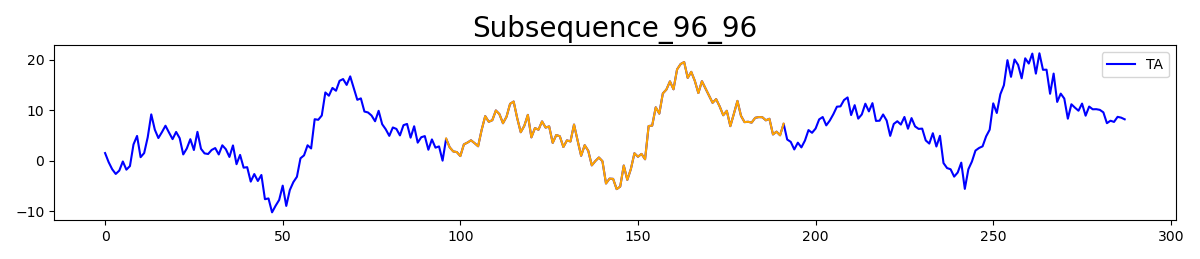

In [54]:
print("Motif found using MP")
data_MPlot.MP_AB.get_motif_idx()
print(data_MPlot.MP_AB.motif_idx)

init = data_MPlot.MP_AB.motif_idx - m
final = init+3*m
print(f"Plotted: ts[{init},{final}] => {data_MPlot.MP_AB.motif_idx} subsequence index changes to {data_MPlot.MP_AB.motif_idx-init}")

mplots.plot_subsequence(
    TA = ts[init:final],
    sequence_i = data_MPlot.MP_AB.motif_idx-init,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    subsequence_color = "orange"
)


Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 806
Plot Interactive | Distances:  [38.665652834123414 38.550102305352475 37.97585370238174 ...
 32.643402127658355 32.903648528634896 33.51818341922461]
Plot Interactive | Window [0, 1920]


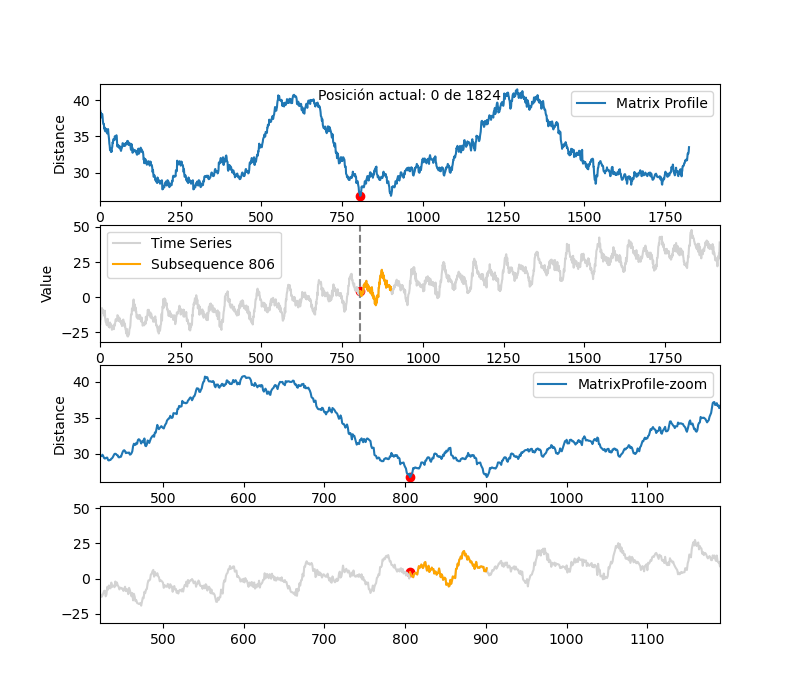

In [55]:
%matplotlib widget
# Max points to plot
data_MPlot.MP_AB.max_points = 3000
data_MPlot.MP_AB.plot_interactive(print_flag = True, figsize=(8,7))

#### Setting up a threshold

It has been checked that, at least for pulsus raxodus, STUMP separates more the distances than SCAMP, so the proposed thresholds show similar plots for the specific case.

In [56]:
# Threshold per method
threshold_scamp = 10
threshold_stump = 7.5
# Select the threshold for the method used for the computation
threshold = threshold_stump if data_MPlot.DM_AB.method == 'stump' else threshold_scamp

#### Visualizing the MPlot in gray scale

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;TODO: check, the gray_color flag is in the opposite way... 
    </div>
</div>

- El patrón es el mismo, cada vez un poco más para arriba
- Eso significa que la distancia debe ser cada vez un poco mayor entre unos y otros (en este caso de manera constante)
- Si miro una fila/columna de la matriz de similitud, debería ser cada número (saltando de m en m) un poco mayor que el siguiente
- En los colores se debería ver cada vez más distancia entre unos y otros. 

In [57]:
print(data_MPlot.DM_AB.distances[0][0:m+1])
print(data_MPlot.DM_AB.distances[0][m:2*m+1])
total = len(data_MPlot.DM_AB.distances[0])
print(data_MPlot.DM_AB.distances[0][total:total-m+1])


[ 0.         21.02700062 24.71972206 30.20780847 36.45458224 41.46778502
 47.01337171 51.17933359 56.54847429 61.95753864 67.59044124 71.26698708
 75.61653987 78.64237213 81.56669814 84.33485704 85.05365219 87.27898876
 88.0573064  89.33787237 89.72211254 90.1850823  90.64385439 90.59807638
 90.1604593  89.64980804 89.74378523 88.74290132 88.66689158 87.86095924
 87.44409792 86.61679703 85.62870355 84.31041342 83.03350853 81.75360736
 79.4610334  78.12238238 75.36906456 72.71815582 70.30507955 67.10710686
 65.129352   61.74911236 60.00876241 57.94067305 56.39672041 54.92634993
 54.50918272 54.42283201 55.2880044  57.24818407 58.62382061 62.47716976
 64.64189011 67.56493352 70.57714253 72.96072193 76.53805327 78.51116758
 80.76202241 83.46189191 85.00780488 86.44309287 87.85097054 89.36541869
 90.3527879  91.14862758 91.44072921 92.72446511 92.73107533 93.00303101
 93.44925319 93.1219848  93.73114281 93.18630053 92.77806315 92.57123968
 92.08512808 90.75351921 88.96406504 87.27309666 85

Threshold: 7.5 | Mehod: stump


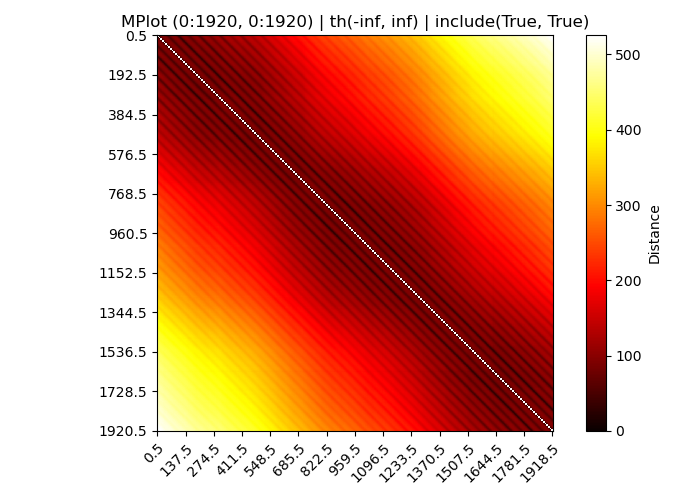

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [58]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

#### Tratando de definir una distancia buena para ver tendencias

##### CityBlock

In [68]:
def manhattan(
    vector_a    = np.array([0]),
    vector_b    = np.array([0]), 
    print_flag  = False, 
    print_depth = 1, 
    time_flag   = False
):
    t = 0
    if time_flag: 
        timer = dvats.utils.Time()
        timer.start()
        
    if print_flag and print_depth > 0: 
        print(f"Vectors: a: {vector_a} b: {vector_b}")
    distance = cityblock(vector_a, vector_b)
    if time_flag:
        timer.end()
        t = timer.duration()
    return distance, t

In [60]:
data_MPlot_trend_manhattan = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [69]:
data_MPlot_trend_manhattan.compute(
    mp_method           = 'stump', 
    dm_method           = 'naive',
    d                   = manhattan,
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    print_depth         = 1,
    threads             = 1,
    gpus                = [1]
)

MatrixProfilePlot | Distance: manhattan
MatrixProfilePlot | Compute | No range provided
MatrixProfilePlot | Compute | Range [0:1920, 0:1920]
MPlot | Compute | Do not downsample => use original time series
MPlot | Compute | --> Ensure parameters 
MPlot | Compute | --> provide_len 
MPlot | Compute | --> provide_len | data ~  (1920,)
MPlot | Compute | --> provide_len | data.MP_AB ~  (1920,)
MPlot | Compute | --> provide_len ... 3 ...
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 1920 ---> 
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
MatrixProfilePlot | Compute | Final Range [0:1920, 0:1920]
MPlot | Compute | --> Instantiate DM & MP | TA ~ 1920 | TB ~ 1920
MPlot | Compute | ... Checking inicializations ...
MP_AB self_join False
DM_AB self_join False
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive
MP_AB data_b ~ 1920
DM_AB data_b ~ 1920
MPlot | Compute | ... Checking inicializations ...
MPlot | Compute | --> Com

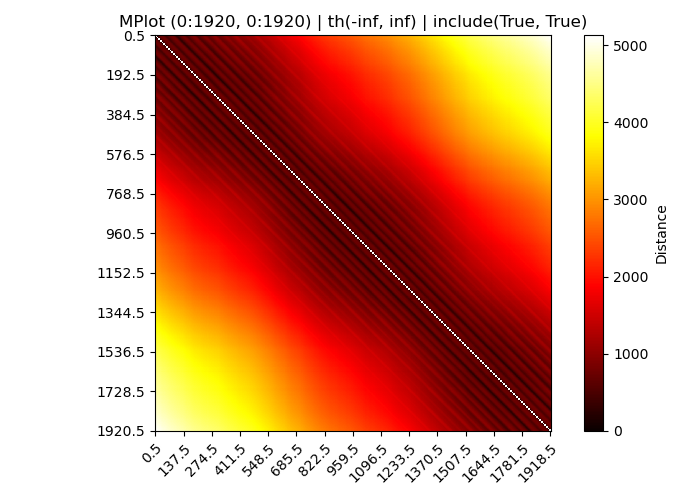

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [70]:
data_MPlot_trend_manhattan.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

##### Trying to be able to detect both up and down trends

In [92]:
min_k = np.min(ts)
max_k = np.max(ts)

def height_distance(
    vector_a    = np.array([0]),
    vector_b    = np.array([0]), 
    print_flag  = False, 
    print_depth = 1, 
    time_flag   = False
):
    t = 0
    if time_flag: 
        timer = dvats.utils.Time()
        timer.start()
        
    if print_flag and print_depth > 0: 
        print(f"Vectors: a: {vector_a} b: {vector_b}")
    normalized_mean_u = (vector_a.mean() - min_k)/(max_k - min_k)
    normalized_mean_v = (vector_b.mean() - min_k)/(max_k - min_k)
    distance = normalized_mean_u - normalized_mean_v
    if time_flag:
        timer.end()
        t = timer.duration()
    return distance + max_k - min_k, t

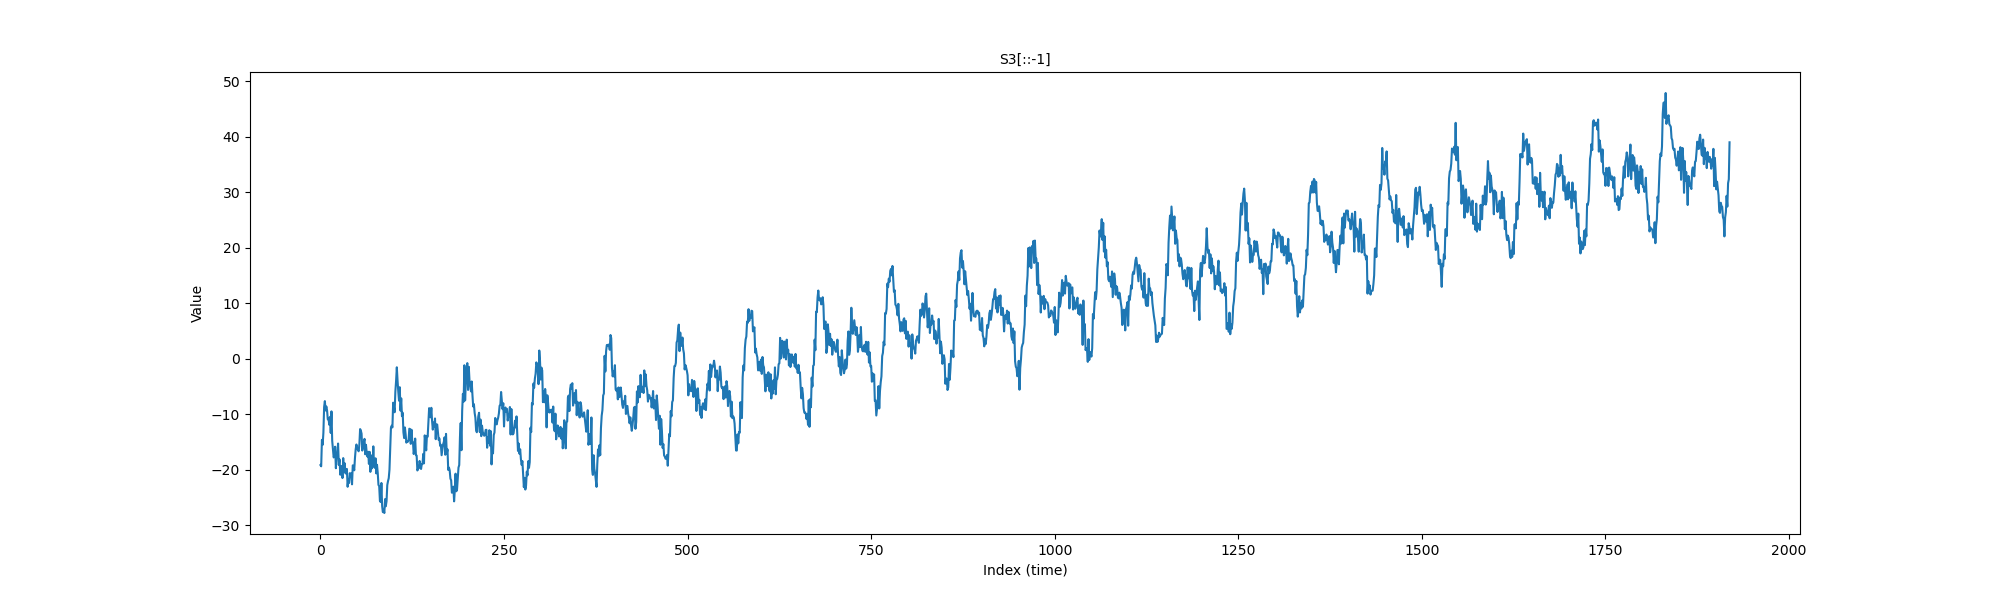

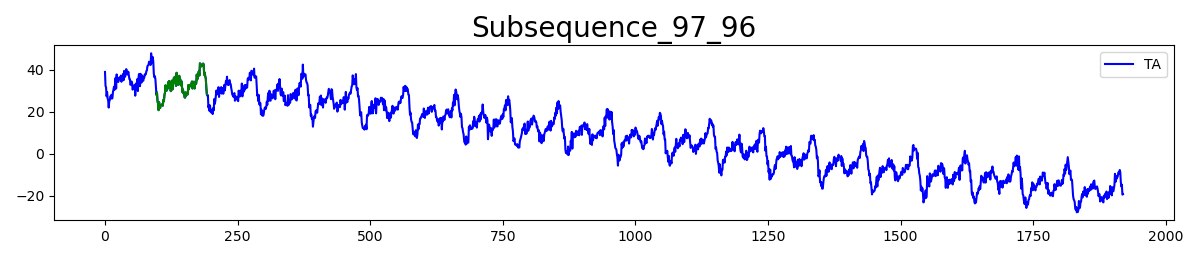

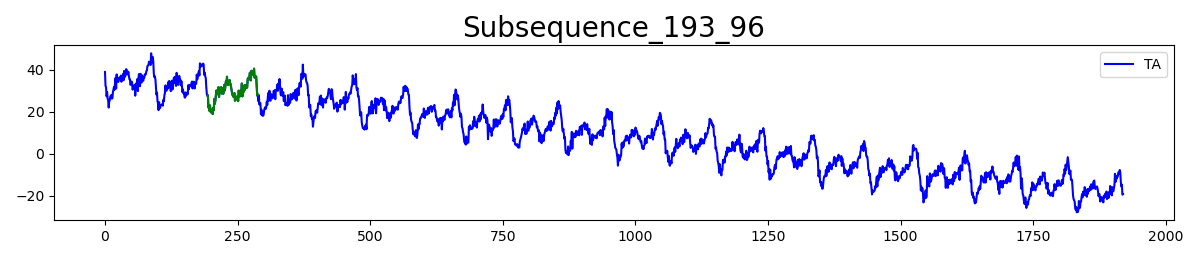

In [91]:
plt.close("all")
mplots.plot_with_dots(
    time_series = ts, 
    title = "S3[::-1]", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (20,6)
)
mplots.plot_subsequence(
    TA = ts[::-1], 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[::-1], 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

In [73]:
ts_ = ts[::-1]
print("Euclidean")
print(euclidean(ts_[0:m], ts_[m:m+m]))
print(euclidean(ts_[m:m+m], ts_[10*m:10*m+m]))
print(euclidean(ts_[0:m], ts_[10*m:10*m+m]))

Euclidean
33.51818341922456
242.6145409799876
269.7179517248764


In [81]:
print("Height TS_")
print(height_distance(vector_a = ts_[0:m], vector_b = ts_[m:m+m], print_flag = False, print_depth = 1, time_flag = True))
print(height_distance(ts_[m:m+m], ts_[10*m:10*m+m]))
print(height_distance(ts_[0:m], ts_[10*m:10*m+m]))

Height TS_
(75.66194171041317, 0.00016188621520996094)
(75.37234004744127, 0)
(75.33583401192143, 0)


In [82]:
print("Height TS")
print(height_distance(ts[0:m], ts[m:m+m]))
print(height_distance(ts[m:m+m], ts[10*m:10*m+m]))
print(height_distance(ts[0:m], ts[10*m:10*m+m]))

Height TS
(75.74360549231218, 0)
(76.02963671296865, 0)
(76.07479445934783, 0)


In [76]:
data_MPlot_trend = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [94]:
data_MPlot_trend.compute(
    mp_method           = 'stump', 
    dm_method           = 'naive',
    d                   = height_distance,
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

MatrixProfilePlot | Distance: height_distance
MPlot | Compute | Do not downsample => use original time series
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 1920 ---> 
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
--> matrix profile
DistanceMatrix | Distance: height_distance
matrix profile 30.603832006454468 seconds -->


In [79]:
data_MPlot_trend.DM_AB.distances

array([[75.69569661, 75.69569661, 75.69569661, ..., 75.69569661,
        75.69569661, 75.69569661],
       [        inf,         inf,         inf, ..., 75.69569661,
        75.69569661, 75.69569661],
       [        inf,         inf,         inf, ..., 75.69569661,
        75.69569661, 75.69569661],
       ...,
       [75.69569661, 75.69569661, 75.69569661, ...,         inf,
                inf,         inf],
       [75.69569661, 75.69569661, 75.69569661, ...,         inf,
                inf,         inf],
       [75.69569661, 75.69569661, 75.69569661, ...,         inf,
                inf,         inf]])

Threshold: 7.5 | Mehod: stump


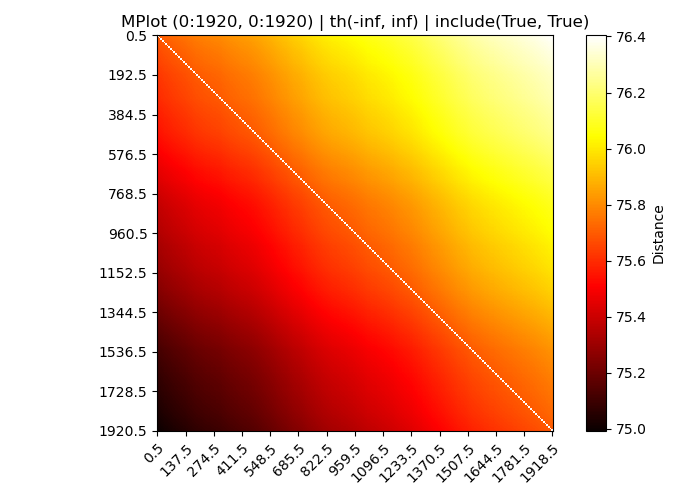

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [95]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot_trend.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

Comprobando tendencia a la baja

In [96]:
data_MPlot_trend_down = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts[::-1], 
    data_b          = ts[::-1],
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [97]:
data_MPlot_trend_down.compute(
    mp_method           = 'stump', 
    dm_method           = 'naive',
    d                   = height_distance,
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

MatrixProfilePlot | Distance: height_distance
MPlot | Compute | Do not downsample => use original time series
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 1920 ---> 
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
Ensure valid limits | Original [0, 1920]
Final [0, 1920]
--> matrix profile
DistanceMatrix | Distance: height_distance
matrix profile 29.76031732559204 seconds -->


In [87]:
data_MPlot_trend_down.DM_AB.distances

array([[75.69844775, 75.69943808, 75.70001011, ..., 76.40219185,
        76.40319949, 76.40412457],
       [        inf,         inf,         inf, ..., 76.40120151,
        76.40220915, 76.40313424],
       [        inf,         inf,         inf, ..., 76.40062949,
        76.40163713, 76.40256221],
       ...,
       [74.99470364, 74.99569398, 74.99626601, ...,         inf,
                inf,         inf],
       [74.993696  , 74.99468634, 74.99525837, ...,         inf,
                inf,         inf],
       [74.99277092, 74.99376126, 74.99433328, ...,         inf,
                inf,         inf]])

Threshold: 7.5 | Mehod: stump


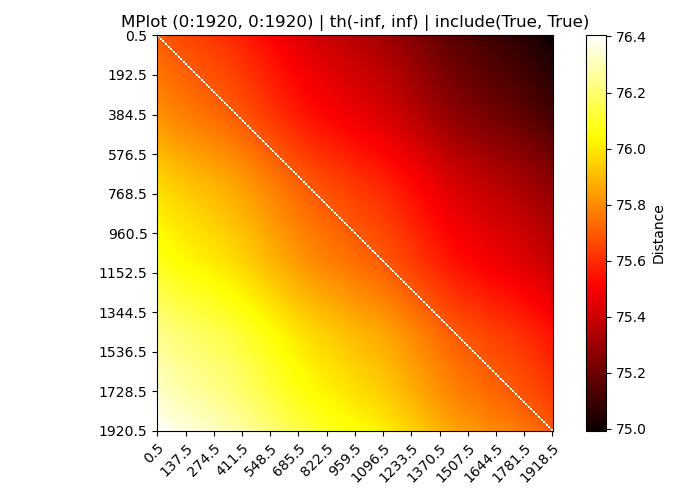

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [98]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot_trend_down.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

In [70]:
run.finish()
if reset_kernel:
    os._exit(00)